# INTRODUCTION TO MACHINE LEARNING: SUPERVISED LEARNING

# **CETACEAN IMAGE CLASSIFICATION**

# **Introduction**

This project is about developing a machine learning model for image classification, with a focus on identifying cetacean species from a dataset of photographs portraying their dorsal fin or their tail. The dataset consists of images taken by enthusiasts during whale watching activities, making it a real-world challenge with diverse and non-standardized inputs. The task is a supervised learning problem, specifically a multi-class classification, where the objective is to accurately classify images into different cetacean species.

The goal of this project is to apply my data science skills to a subject I am passionate about—natural and environmental issues, giving me the opportunity to explore how my knowledge can be used in contexts that I care deeply about. This project represents a step toward what I hope to pursue in my future professional life: using data science to address issues in nature and the environment.

To perform this classification I will use three different ML models that we learned in this course: KNN Classifier, GradientBoosting Classifier and Random Forest Classifier

Let's begin by importing all the required libraries.

In [1]:
# Importing libraries
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from PIL import Image
from skimage.measure import shannon_entropy
from skimage.color import rgb2gray
from skimage.feature import graycomatrix, graycoprops
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, make_scorer, confusion_matrix, precision_recall_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import random as rnd

# **DATA DESCRIPTION AND DATA CLEANING**

The dataset I am using for this project is sourced from Kaggle and is titled "Happy Whale Images Sorted By Species" (https://www.kaggle.com/datasets/andrewgustyjrstudent/happywhaleimagessortedbyspecies?select=train_species_list). The data is 1.55 GB in size and consists of 30 directories, each representing a different cetacean species. All the images are in JPG format and are in color, providing rich visual information for training the classification models.

Before performing any data cleaning on my dataset, I want to first check how many photos are contained in each of my folders. This step helpes me understand the distribution of images across different cetacean species. Knowing the number of photos in each folder is crucial for deciding the best approach to proceed with my analysis, as it informs me about the balance of the dataset and potential issues related to class imbalance.

In [2]:
# Create a dict to count the images I have for each species, then show a histogram
species_count = {
    'beluga': 0,
    'blue_whale': 0,
    'bottlenose_dolphin': 0,
    'bottlenose_dolpin': 0,
    'brydes_whale': 0,
    'commersons_dolphin': 0,
    'common_dolphin': 0,
    'cuviers_beaked_whale': 0,
    'dusky_dolphin': 0,
    'false_killer_whale': 0,
    'fin_whale': 0,
    'frasiers_dolphin': 0,
    'globis': 0,
    'gray_whale': 0,
    'humpback_whale': 0,
    'kiler_whale': 0,
    'killer_whale': 0,
    'long_finned_pilot_whale': 0,
    'melon_headed_whale': 0,
    'minke_whale': 0,
    'pantropic_spotted_dolphin': 0,
    'pilot_whale': 0,
    'pygmy_killer_whale': 0,
    'rough_toothed_dolphin': 0,
    'sei_whale': 0,
    'short_finned_pilot_whale': 0,
    'southern_right_whale': 0,
    'spinner_dolphin': 0,
    'spotted_dolphin': 0,
    'white_sided_dolphin': 0    
}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        species_name = dirname[dirname.rindex('/')+1:]
        species_count[species_name] += 1

print(species_count)

{'beluga': 7443, 'blue_whale': 4830, 'bottlenose_dolphin': 9664, 'bottlenose_dolpin': 1117, 'brydes_whale': 154, 'commersons_dolphin': 90, 'common_dolphin': 347, 'cuviers_beaked_whale': 341, 'dusky_dolphin': 3139, 'false_killer_whale': 3326, 'fin_whale': 1324, 'frasiers_dolphin': 14, 'globis': 116, 'gray_whale': 1123, 'humpback_whale': 7392, 'kiler_whale': 962, 'killer_whale': 1493, 'long_finned_pilot_whale': 238, 'melon_headed_whale': 1689, 'minke_whale': 1608, 'pantropic_spotted_dolphin': 145, 'pilot_whale': 262, 'pygmy_killer_whale': 76, 'rough_toothed_dolphin': 60, 'sei_whale': 428, 'short_finned_pilot_whale': 367, 'southern_right_whale': 866, 'spinner_dolphin': 1700, 'spotted_dolphin': 490, 'white_sided_dolphin': 229}


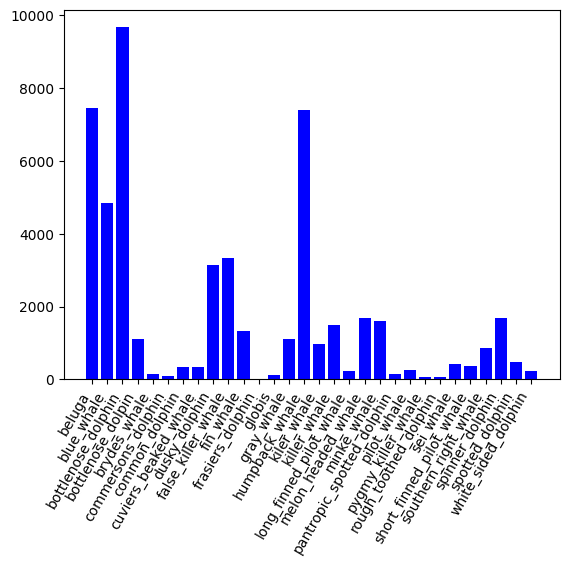

In [3]:
plt.bar(list(species_count.keys()), species_count.values(), color='b')
plt.xticks(rotation=60, ha='right')
plt.show()

As shown by the histogram, we can see the data is extremely unbalanced: a few folders contain thousands of photos, while most of them contain only hundreds. To prevent problems arising from unbalanced data as well as inconclusive results due to lack of data, I decide to focus on the top three folders, which contain the majority of my images. By limiting my analysis to these folders, I aim to achieve more accurate and meaningful results.

At this stage, I extract images from the 'beluga'(7443), 'humpback whale'(7392), and 'bottlenose dolphin'(9664) directories. In order to ensure equal representation from each category, I want to perform a little undersampling to reduce the number of images to 7350 per species. I achieve this by selecting the first 7350 photos from each folder, legitimately assuming that this collection of non-organized and not ordered images holds a built-in randomness. Under this assumptions, we can fairly get rid of folders where the name of species is clearly misspelled, like "bottlenose_dolpin" or "kiler_whale".<br>
Finally, I convert each JPG file into an array of pixels and transform them to RGB format. I then compile all these images into a newly created list, preparing the data for subsequent analysis and model training.

In [4]:
# Create a list of my image data + undersampling 7350
species = ["beluga","humpback_whale","bottlenose_dolphin"]
photo_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    count = 0
    for filename in filenames:
        if count < 7350:
            if dirname[dirname.rindex('/')+1:] in species:
                img_path = os.path.join(dirname, filename)  # re-build all the path to image file
                img = cv2.imread(img_path)                  # here cv2 transforms the file (jpg) in an nparray
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                photo_list.append(img)
                count += 1

print(len(photo_list))

22050


Here is a sample of the final images I am going to use in my analysis. Specifically, the grid below displays a random sample of images from my dataset which helps to get a sense of the variety and quality of the images.

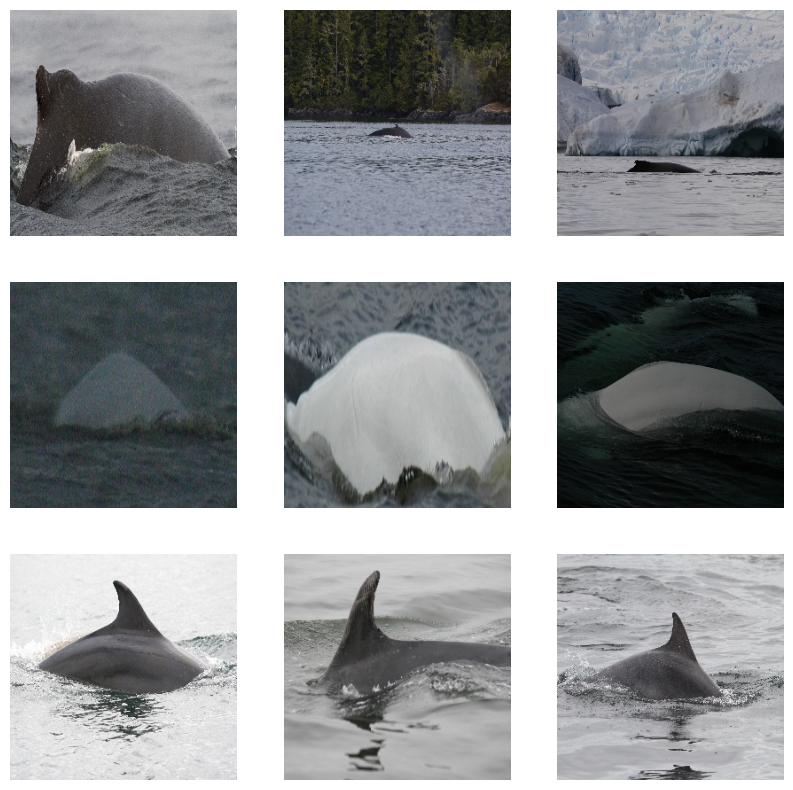

In [5]:
# Visualizing Sample Images
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # setup plot grid: 3x3 grid of 10x10 pics (subplots)
for i, ax in enumerate(axes.flat):                # for each row and for each col in the 3x3 grid
    ax.imshow(photo_list[rnd.randint(7350*(i/3),7350*((i+1)/3))], cmap='gray')         # show i-th image (nparray) of list photo_list. ax element is an axis (from matplotlib)
    ax.axis('off')                                # dont show axis in each subplot
plt.show()


As the last step, it is important to verify that all the images have the same size. The two following histograms show the distribution of image sizes both for width and for height, indicating all images are 256x256 pixels. 

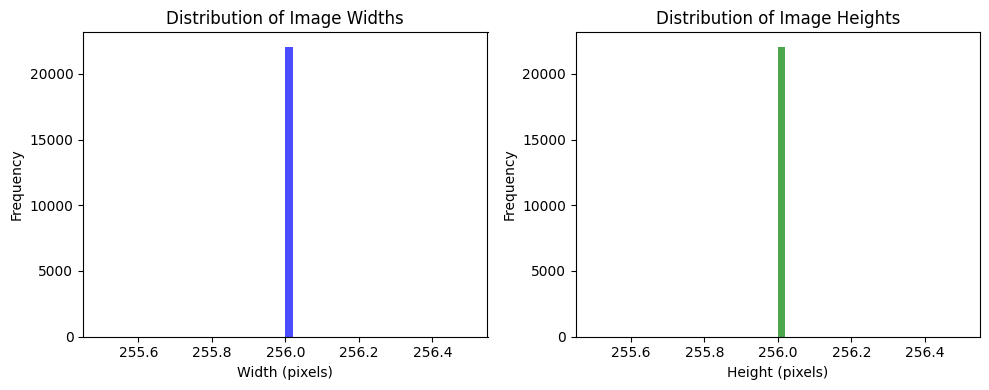

In [6]:
# Image Size and Aspect Ratio
# Size Distribution: Plot the distribution of image sizes (width and height).

widths = [image.shape[1] for image in photo_list]
heights = [image.shape[0] for image in photo_list]

plt.figure(figsize=(10, 4))

# Histogram for image widths
plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')

# Histogram for image heights
plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


# **EXPLORATORY DATA ANALYSIS**

Performing an exploratory data analysis on data is crucial since it helps to fully understand the inner aspects of the dataset. In my EDA, I will perform several analysis on the selected images, including aspects such as distribution of pixel values, average intensity of the images, color distribution, contrast and entropy. First thing to do is to convert the list of photos created above in a numpy array. 

In [7]:
np_photo_list = np.array(photo_list)  # convert photo_list in a nparray

**PIXEL VALUE DISTRIBUTION**

This analysis helps identify the range and frequency of pixel values across images in the cleaned dataset. Understanding pixel value distribution is crucial for preprocessing steps and for identifying any anomalies or outliers in the image data. Here I plotted a histogram that shows their distribution.

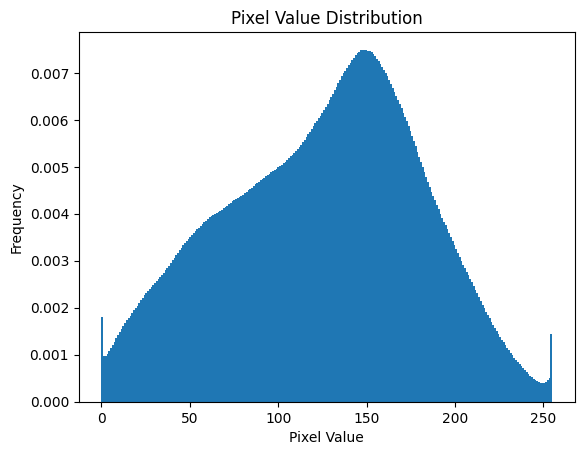

In [8]:
# Pixel Value Distribution
pixel_values = np_photo_list.flatten()
plt.hist(pixel_values, bins=256, range=(0, 255), density=True) # density True is the freq normalized to 1 (i.e. in a probabilistic sense)
                                                               # density False is the absolute frequency, so a classic histogram
plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()

As said above, the chart illustrates the distribution of pixel values across photos in the dataset belonging to the three selected species. The x-axis represents the pixel values ranging from 0 to 255, where 0 is black, 255 is white. The y-axis shows the frequency of these pixel values, normalized to a maximum of 1. The distribution indicates that the pixel values are spread across the entire range, with a higher concentration between approximately 100 and 200.<br>
This suggests that the photos predominantly contain mid-range pixel values, resulting in images that are neither too dark nor too bright. The peak around 150 suggests that most of them are in this mid-tone range, which might be due to the nature of the cetacean images and their oceanic environment. Additionally, there are smaller frequencies at the extreme ends (near 0 and 255), indicating the presence of some very dark and very bright pixels.

**AVERAGE INTENSITY OF THE IMAGES**

By examining the average intensity of the images, it is possible to assess the overall brightness levels within the dataset. This information is useful for detecting any images that are too dark or too bright, which may need adjustment to ensure uniformity. 

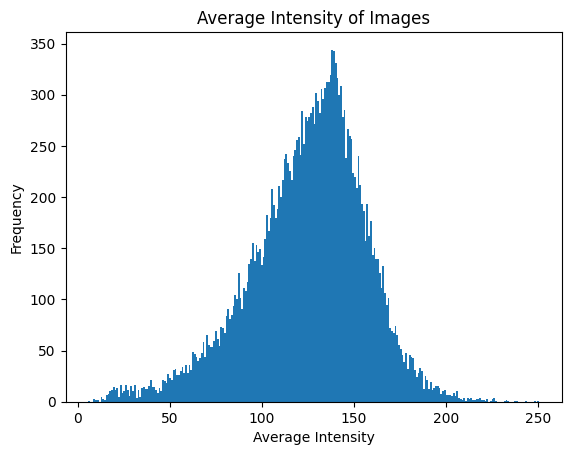

In [9]:
# Image Intensity
avg_intensity = [np.mean(image) for image in np_photo_list]  # computes the mean value of each single img in np_photo_list
plt.hist(avg_intensity, bins=256)
plt.title('Average Intensity of Images')
plt.xlabel('Average Intensity')
plt.ylabel('Frequency')
plt.show()

The chart presents the distribution of average intensity values for the images in the dataset. As in the previous histogram, the x-axis represents the average intensity values, ranging from 0 to 255, where 0 is black, 255 is white. The y-axis shows the frequency of these average intensity values.<br>
The distribution is roughly bell-shaped, peaking around an average intensity value of approximately 130-140. This indicates that most images have a mid-range average intensity, confirming that they are neither too dark nor too bright overall. The symmetrical shape of the distribution suggests that the dataset contains a balanced variety of images in terms of brightness.<br>
There are fewer images with extremely low or high average intensity values, as evidenced by the lower frequencies towards the ends of the x-axis. This means that very dark or very bright images are less common in the dataset. 

**RGB COLOR DISTRIBUTION**

Analyzing the distribution of colors (red, green, and blue channels) provides insight into the color balance and composition of the images. This can help understand the visual characteristics of the dataset and can theoretically inform color-related preprocessing steps, such as color normalization or augmentation. <br>
The next three histograms display the distribution of pixel values for the red, green, and blue color channels across all the photos in the dataset. Each plot provides insight into how frequently each pixel value (ranging from 0 to 255) occurs in each color channel.

In [10]:
max_frequency = 0

# Calculate the maximum frequency across all channels
for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], range(3))):
    color_values = np_photo_list[:, :, :, channel].flatten()
    hist, bins = np.histogram(color_values, bins=256)
    max_frequency = max(max_frequency, max(hist))

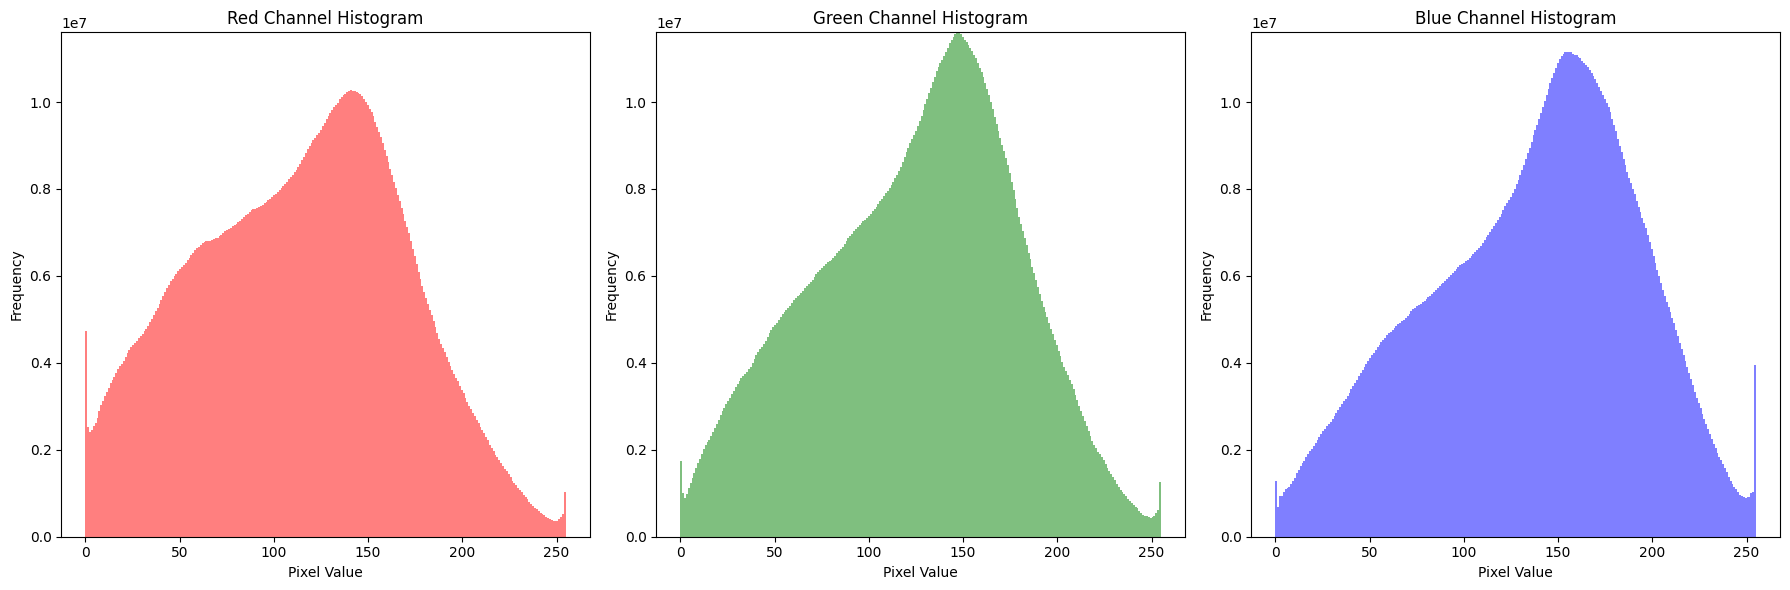

In [11]:
# Plot histograms with a consistent y-axis scale

fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (18,6))

for i, (color, channel) in enumerate(zip(['Red', 'Green', 'Blue'], range(3))):
    plt.subplot(1, 3, i+1)
    color_values = np_photo_list[:, :, :, channel].flatten()
    plt.hist(color_values, bins=256, alpha=0.5, color=color.lower())
    plt.title(f'{color} Channel Histogram')
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.ylim(0, max_frequency)  # Set the y-axis limit to the maximum frequency

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

All three histograms show that the pixel values in each color channel are predominantly within the mid-range (approximately 100-200), indicating that the images have a balanced distribution of color intensities without extreme dark or bright areas. The peaks in each histogram around the mid-tone values suggest that the images have a natural and well-balanced color distribution, which is typical for photographs taken in natural environments. The similarity in the shape of the distributions across the three channels indicates that the images are well-balanced in terms of color, without any single channel dominating the color composition.

**ENTROPY AND CONTRAST**

Entropy measures the randomness or complexity within the images. High entropy values indicate more detailed and complex images, while low entropy values suggest simpler images with less variation. This analysis helps in understanding the diversity and texture of the dataset, which can influence feature extraction and model performance.<br>
Measuring the contrast in images helps determine the difference in luminance or color that makes objects distinguishable. High contrast can indicate clear and distinct features, while low contrast may suggest the need for enhancement techniques to improve feature visibility.

In [12]:
# Compute contrast from image
def compute_contrast(pic):
    try:
        #img = pic.convert('RGB')
        gray_img = rgb2gray(np.array(pic))
        # Compute GLCM
        glcm = graycomatrix((gray_img * 255).astype(np.uint8), distances=[1], angles=[0], symmetric=True, normed=True)
        # Extract contrast
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        return contrast
    except Exception as e:
        print(f"Error processing image {pic}: {e}")
        return None

contrasts = []
for el in np_photo_list:
    contrast = compute_contrast(el)
    if contrast is not None:
        contrasts.append(contrast)

*NOTE: the following cell may take a long time to complete execution*

In [13]:
# Compute entropy
entropies = [shannon_entropy(image) for image in np_photo_list]

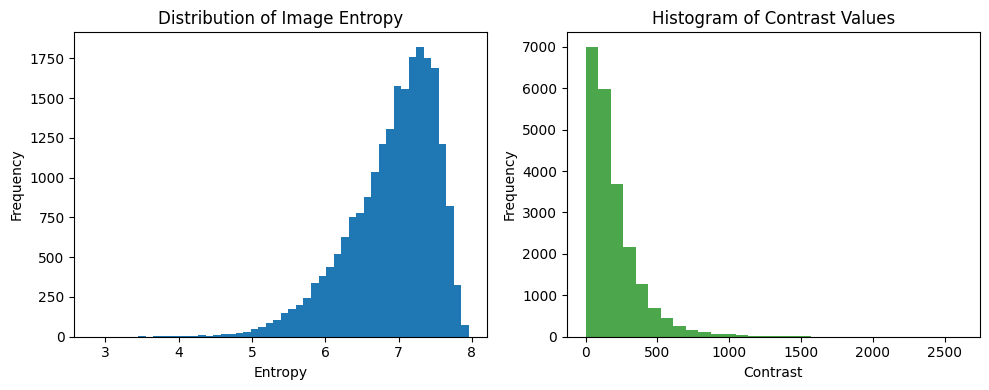

In [14]:
plt.figure(figsize=(10, 4))

# Plot histogram of entropy values
plt.subplot(1, 2, 1)
plt.hist(entropies, bins=50)
plt.title('Distribution of Image Entropy')
plt.xlabel('Entropy')
plt.ylabel('Frequency')

# Plot histogram of contrast values
plt.subplot(1, 2, 2)
plt.hist(contrasts, bins=30, color='green', alpha=0.7)
plt.title('Histogram of Contrast Values')
plt.xlabel('Contrast')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

The left plot shows the distribution of image entropy across all images in the dataset. High entropy values indicate more complexity and variety in the pixel values, which usually correspond to more detailed or textured images.<br>
Most images have entropy values between 5 and 7, with a peak around 6.5 to 7. The distribution is left-skewed, meaning there are fewer images with lower entropy values and a gradual increase in the number of images as entropy increases.<br>
This suggests that most images in the dataset have a moderate to high level of detail and complexity. The fewer low-entropy images might be simpler or less detailed, which is less common in the dataset.

The right-hand-side chart depicts the histogram of contrast values across all images. Contrast refers to the difference in luminance or color that makes an object distinguishable from other objects within the same field of view.<br>
The contrast values range from 0 to about 2500. The majority of images have contrast values below 500, with a significant peak at lower contrast values. The distribution is highly right-skewed, with a very large number of images having low contrast values (close to 0) and progressively fewer images as contrast values increase.<br>
This suggests that many images in the dataset have low contrast, indicating that they may have less differentiation in luminance or color within the image.

In conclusion, the moderate to high entropy values indicate that the dataset contains a variety of detailed images, which is beneficial for training robust machine learning models.
The prevalence of low-contrast images might indicate that many images have subtle differences in pixel values, which could be challenging for certain types of image recognition tasks.

**EDA CONCLUSIONS**

Overall, the dataset appears to be quite rich and diverse, capturing a wide range of visual features including varying brightness levels, color distributions, textures, and contrasts. The balance in color channels and the normal distribution of average intensity values indicate that the images are natural and not artificially manipulated, which is crucial for developing models that perform well on real-world data.<br>
On the other hand, the variability in contrast and intensity suggests that some images might be of lower quality or taken in non-optimal conditions. Think about photos taken from a moving boat, other with sunlight direclty in front of camera or simply blurred images.

# **ANALYSIS AND RESULTS**

In this section I perform the actual analysis of the images selected from my dataset. I chose three models because they offer a diverse set of approaches to handle the complexity and high dimensionality of image data. The models I used for this purpose are the following:

    KNN Classifier
    Random Forest Classifier
    GradientBoosting Classifier
   
Regarding the application of common concepts seen in the course in image classification, collinearity (or multicollinearity), which is common in traditional regression models, is not directly applicable in the same way. In images, adjacent pixels are often highly correlated because they represent spatially contiguous parts of the scene. Therefore, this high correlation is an expected and natural characteristic of image data.

In the following steps, I define all the labels in which each image has to be categorized. Such labels can be inferred directly from the path of each image within the database. Next, all the features are derived by resizing and flattening the image into an array of pixels. Then, measuring their contribution for each color channel, each pixel is considered as a feature for my model.

In [15]:
# Collect image paths and labels
def collect_image_paths_and_labels(root_dir, label_map):
    image_paths = []
    labels = []
    for label, subdir in label_map.items():
        count = 0
        subdir_path = os.path.join(root_dir, subdir)
        for filename in os.listdir(subdir_path):
            if count<7350:
                if filename.endswith(('.png', '.jpg', '.jpeg')):
                    image_paths.append(os.path.join(subdir_path, filename))
                    labels.append(label)
                    count+=1
    return image_paths, labels


# Extract color histograms
def extract_color_histograms(image_paths, bins=256):
    features = []
    for img_path in image_paths:
        try:
            img = Image.open(img_path).convert('RGB')
            img = img.resize((128, 128))  # Resize for consistency
            hist_features = []
            for channel in range(3):
                channel_values = np.array(img)[:, :, channel].flatten()
                hist, _ = np.histogram(channel_values, bins=bins, range=(0, 256))
                #print(hist)
                hist_features.extend(hist)
            features.append(hist_features)
        except Exception as e:
            print(f"Error processing image {img_path}: {e}")
    return np.array(features)


*NOTE: the following cell may take a long time to complete execution*

In [16]:
# Specify the root directory and the subdirectory-to-label mapping
root_dir = '/kaggle/input/happywhaleimagessortedbyspecies/train_species_list'
label_map = {
    0: "beluga",
    1: "humpback_whale",
    2: "bottlenose_dolphin"
}

# Collect image paths and labels
image_paths, labels = collect_image_paths_and_labels(root_dir, label_map)

# Extract color histograms
X = extract_color_histograms(image_paths, bins=256)
y = np.array(labels)

In [17]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 1. K-Nearest Neighbors Classifier

I chose to use the K-Nearest Neighbors (KNN) classifier for my analysis because of its simplicity. KNN classifies a data point based on the majority class among its nearest neighbors, making it easy to understand and interpret. Unlike methods that rely on specific data distribution assumptions, KNN employs a distance-based approach.

Within this analysis, the algorithm directly relies on the distance between feature vectors (which in our case, are the raw RGB pixel intensities of the images).

In [18]:
# Train and evaluate a k-Nearest Neighbors classifier
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
print("k-NN Accuracy:", accuracy_score(y_test, y_pred_knn))
print("k-NN Classification Report:\n", classification_report(y_test, y_pred_knn))

k-NN Accuracy: 0.7272108843537415
k-NN Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.80      0.82      1468
           1       0.69      0.62      0.65      1497
           2       0.66      0.76      0.71      1445

    accuracy                           0.73      4410
   macro avg       0.73      0.73      0.73      4410
weighted avg       0.73      0.73      0.73      4410



In this case, the overall accuracy is 0.73. However, the performance is significantly impacted by Class 1 and Class 2, which correspond to the humpback whale and bottlenose dolphin category. In detail, Class 1 behaves worse showing lower precision, recall, and f1-score, dragging down the overall model performance.<br>
To illustrate these results, I created a confusion matrix. The matrix highlights that, while many predictions are accurate, Class 1 struggles particularly, with only 926 out of 1497 humpback whale photos being correctly identified, indicating a substantial misclassification issue for this category.

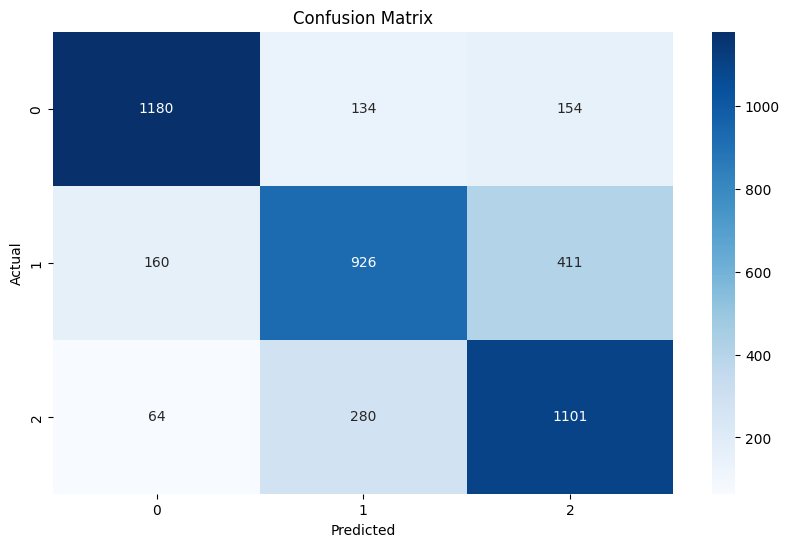

In [19]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In order to assess the quality of KNN Classifier, I additionally performed a Cross Validation routine, computing the score for a range of neighbors included from 1 to 10, thus ensuring that each subset of the dataset is used both for training and validation, giving a better estimate of my model’s performance on unseen data.
Resulting from the code below, the model accuracy gets the highest score for 4 neighbors, confirming the implemented KNN model.

{'n_neighbors': 4} 0.7237528344671202


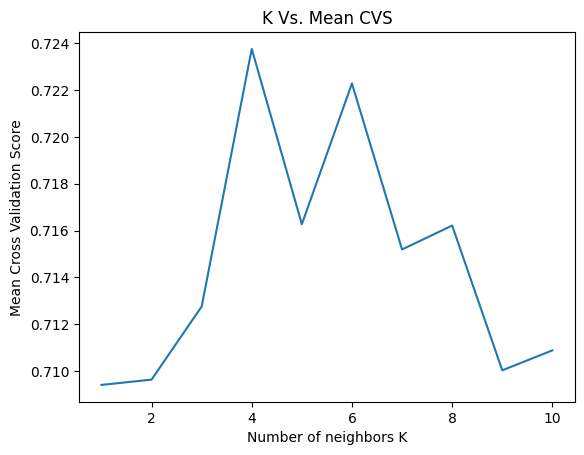

In [20]:
# Mean cross-validation score vs number of neighbor
KNN = KNeighborsClassifier()
num_try = {"n_neighbors" : [i for i in range(1, 11)]}
grid = GridSearchCV(estimator = KNN, param_grid = num_try, n_jobs = -1)

grid.fit(X_train, y_train)

print(grid.best_params_ , grid.best_score_)


# Plot n_neighbors vs mean test score
KNN_res_tot = grid.cv_results_
KNN_results = pd.DataFrame(KNN_res_tot)
n_neighbors = list(KNN_results["param_n_neighbors"])
mean_score = list(KNN_results["mean_test_score"])

plt.plot(n_neighbors, mean_score)
plt.xlabel("Number of neighbors K")
plt.ylabel("Mean Cross Validation Score")
plt.title("K Vs. Mean CVS")
plt.show()

#Accuracy of best KNN estimator
bestKNN = grid.best_estimator_
yhat = bestKNN.predict(X_test)
model_accuracy = accuracy_score(y_true = y_test, y_pred = yhat)

#print("Model accuracy = ", model_accuracy)

# 2. Random Forest Classifier

I chose to use the Random Forest classifier because it is a powerful and versatile ensemble method that combines multiple decision trees to improve classification performance. It reduces the risk of overfitting by averaging the results of many trees, making it robust and reliable for handling high-dimensional image data. This model's balance of accuracy, interpretability, and robustness makes it a suitable choice for an image classification project.

The next step is to evaluate how the number of trees affecs the overall accuracy. To have a glimpse of that, the accuracy is computed on an interval ranging from 50 to 500 trees, with an interval of 50. The cap is set at 500 in order to maintain a feasible complexity and not incur in a timeout from the server during cell execution.

*NOTE: the following cell takes a really long time to complete execution*

In [21]:
# ACCURACY VS NUMBER OF TREES
# Find accuracy for random forest classifiers with trees between (1, 500)
n_trees = [1] + [50 * i for i in range (1, 11)]
accuracy_scores = []

for n in n_trees:
    # Train and get predictions from current random forest
    random_forest = RandomForestClassifier(random_state = 42, n_estimators = n, min_impurity_decrease = .0001, n_jobs = -1)
    random_forest.fit(X_train, y_train)
    yhat = random_forest.predict(X_test)
    #Get accuracy of current random forest
    accuracy = accuracy_score(y_true = y_test, y_pred = yhat)
    accuracy_scores.append(accuracy)

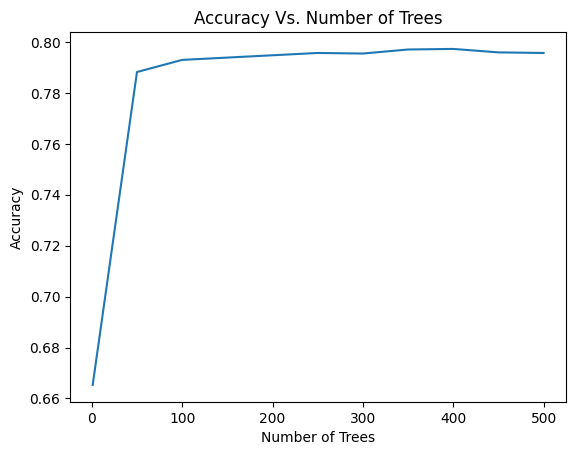

In [22]:
# Plot of Accuracy Vs. Number of Trees
plt.plot(n_trees, accuracy_scores)
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.title("Accuracy Vs. Number of Trees")
plt.show()

In [23]:
# Train and evaluate a Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 0.7988662131519274
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.85      0.86      1468
           1       0.75      0.76      0.76      1497
           2       0.79      0.79      0.79      1445

    accuracy                           0.80      4410
   macro avg       0.80      0.80      0.80      4410
weighted avg       0.80      0.80      0.80      4410



As shown by the summary, the overall accuracy is 0.80, meaning that the model is correctly classifying about 80% of the images. Class 0 has very good performance metrics, while class 1 has the lowest precision and recall, suggesting that the model struggles more with this class compared to the other two.<br>
I chose to set *n_estimators=100* because, as shown in the above plot, this value provides the best trade-off between accuracy and computational efficiency.<br>
With regards to the other hyperparameters, I found that the accuracy of the model worsened when I adjusted them from their default settings. This decline in performance suggests that introducing additional constraints, such as limiting tree depth or adjusting the minimum number of samples per leaf, may have led to underfitting. Therefore, I opted to retain the default values for these hyperparameters to maintain optimal model performance.

Finally, in order to have a counterproof on my model evaluation, I also performed a 5-folds cross-validation. The resulting 0.80 mean cross-validation score implies that the model performs similarly across different folds, a good sign of a consistent and well-generalized model.

In [24]:
# Perform 5-folds cross-validation
rf = RandomForestClassifier()
cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')

# Print the cross-validation scores and the mean of the cross-validation scores
print("Cross-validation scores for each fold: ", cv_scores)
print("Mean cross-validation score: ", np.mean(cv_scores))

Cross-validation scores for each fold:  [0.78401361 0.79421769 0.80045351 0.78571429 0.8064059 ]
Mean cross-validation score:  0.7941609977324263


# 3. Gradient Boosting Classifier

I chose to use the Gradient Boosting classifier for my analysis because it is a powerful boosting technique that builds an ensemble of trees sequentially, with each tree correcting the errors of the previous ones. This iterative approach allows Gradient Boosting to capture complex patterns in the data, which is particularly beneficial for image classification where pixel relationships can be intricate. The model offers many hyperparameters that can be fine-tuned to optimize performance, making it highly customizable.

To optimize my XGBoost model, I began by searching for the best hyperparameter values that would maximize accuracy. I decided to set the max_depth parameter to 5 from the outset to help manage execution time. Then, I explored different values for the n_estimators (number of trees) and learning_rate. Specifically, I varied n_estimators from 50 to 300 and tested learning rates incrementally from 0.2 to 1.0 in steps of 0.2, which provided a balance between a thorough exploration and a manageable computation time.<br>
The results, visualized in a graph of accuracy versus the number of trees and learning rates, revealed that the optimal configuration was 300 trees with a learning rate of 0.4. This combination yielded the highest accuracy, making it the best choice for my model.

In [25]:
# Optimal learning rate in function of the number of trees
learning_rates = [0.2,0.4,0.6,0.8, 1]
n_estimators = [50, 100, 200, 300]

scores = np.zeros((len(learning_rates), len(n_estimators)))

*NOTE: the following cell takes a really long time to complete execution*

In [26]:
for i, lr in enumerate(learning_rates):
    print("i = ", i, "lr =", lr)
    for j, n in enumerate(n_estimators):
        print("j = ", j, "n =", n)
        model = xgb.XGBClassifier(learning_rate=lr, n_estimators=n, max_depth=5)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        scores[i, j] = accuracy_score(y_test, y_pred)

i =  0 lr = 0.2
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  1 lr = 0.4
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  2 lr = 0.6
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  3 lr = 0.8
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300
i =  4 lr = 1
j =  0 n = 50
j =  1 n = 100
j =  2 n = 200
j =  3 n = 300


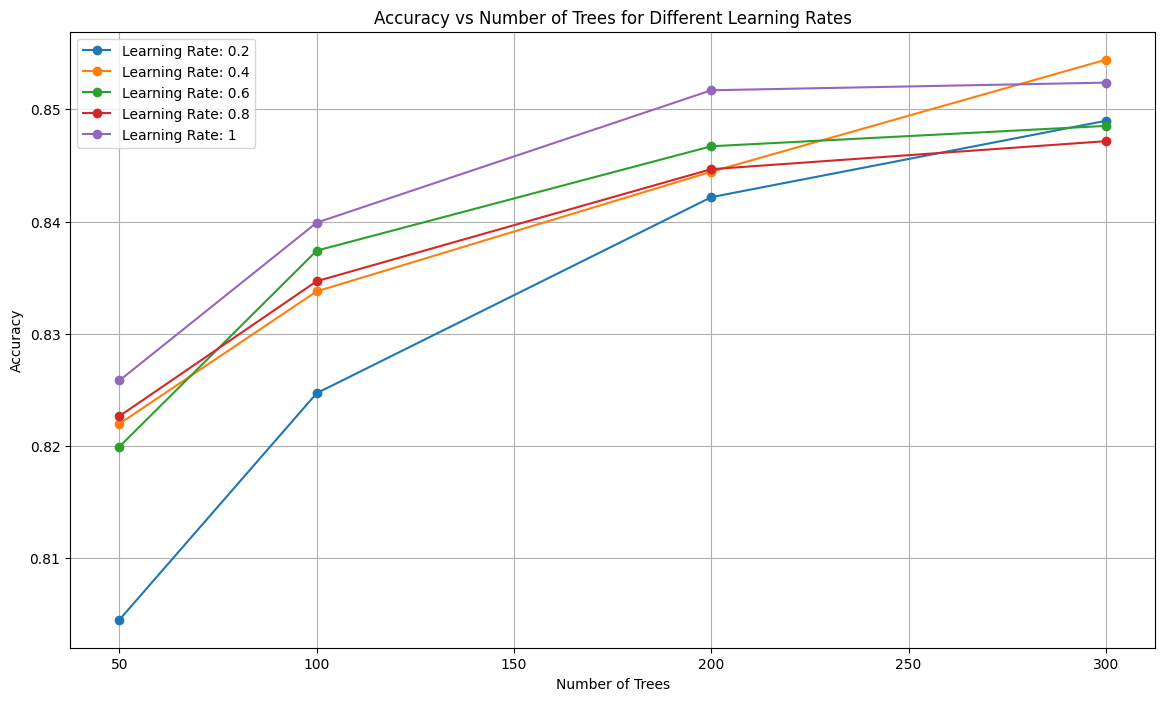

In [27]:
# Plot accuracy vs number of trees for different learning rates
plt.figure(figsize=(14, 8))
for i, lr in enumerate(learning_rates):
    plt.plot(n_estimators, scores[i, :], marker='o', label=f'Learning Rate: {lr}')

plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Trees for Different Learning Rates')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Gradient Boosting
xgb_model = XGBClassifier(n_estimators=300, learning_rate=0.4, max_depth=5, random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.854421768707483
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      1468
           1       0.83      0.82      0.82      1497
           2       0.83      0.85      0.84      1445

    accuracy                           0.85      4410
   macro avg       0.85      0.85      0.85      4410
weighted avg       0.85      0.85      0.85      4410



The XGBoost model achieved an overall accuracy of 0.85. However, similarly to the other two models, Class 0 (Beluga) consistently performed well, showing higher precision, recall, and F1-score compared to the other classes, which however provided very good results.

Therefore, I plotted a precision-recall graph to visually demonstrate the different performance levels of the model for each class. The graph clearly illustrates what we observed earlier: the orange curve, which corresponds to Class 1, is lower than the curves for the other two classes. This highlights the consistently poorer performance of the model in predicting Class 1 compared to the others. On the other hand, the blue curve of Class 0 presents a bigger area under the curve, highlighting better performances for this class.

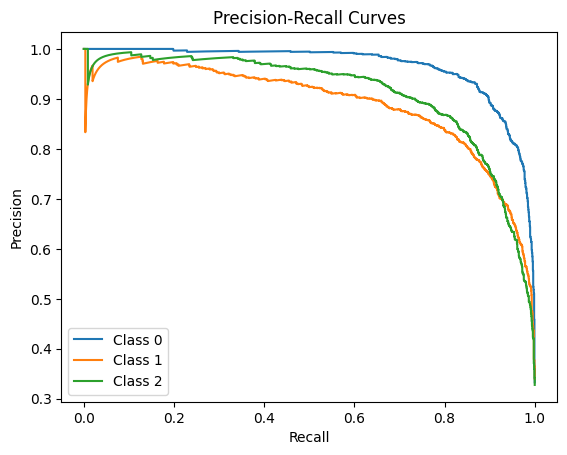

In [29]:
# Precision-Recall Curves
y_test_bin = label_binarize(y_test, classes=[i for i in range(3)])
y_score = xgb_model.predict_proba(X_test)

plt.figure()

for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    plt.plot(recall, precision, label=f'Class {i}')
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='lower left')
plt.show()

# **DISCUSSION AND CONCLUSIONS**

In this project, I explored the challenging task of image classification for identifying cetacean species using three different models: Random Forest, K-Nearest Neighbors (KNN), and Gradient Boosting (XGBoost). Through this process, I learned a great deal about the complexities of image data and the importance of carefully tuning model parameters.

One of the key takeaways is the importance of understanding the characteristics of the dataset. Despite balancing the data, I consistently observed that all three models struggled a bit more with Class 1 (i.e. the Humpback Whale), while they performed well on Class 0 in particular. This indicates that the features distinguishing this class might be strong or easily detectable, suggesting that the model may be capturing the necessary details for accurate classification.

In terms of model performance, the Random Forest classifier demonstrated good accuracy with default parameters, but performance deteriorated when additional parameters were tuned. This likely indicates issues with underfitting when too many computational constraints were applied. The KNN model, while simple, achieved decent accuracy, but again struggled with the Humpback Whale and the Bottlenose Dolphin, possibly due to the difficulty in distinguishing features. XGBoost proved to be the most effective model, achieving the highest accuracy, especially with Class 0. The use of a precision-recall graph further highlighted this behaviour, showing a performance difference between Class 0 and the other classes.

To improve the results, future work could focus on enhancing feature extraction, such as incorporating more advanced image processing techniques or experimenting with different types of data augmentation. Additionally, trying more sophisticated models, such as convolutional neural networks (CNNs), might help capture more nuanced features that are critical for distinguishing between classes.

# Bibliography

Data can be downloaded on Kaggle at https://www.kaggle.com/datasets/andrewgustyjrstudent/happywhaleimagessortedbyspecies?select=train_species_list under the title "Happy Whale Images Sorted By Species".

Interesting documentation sources I used:

1. Happywhale website (https://happywhale.com/home)

2. P. Patton et al (2023). "A deep learning approach to photo–identification demonstrates high performance on two dozen cetacean species"<br>
DOI:  https://doi.org/10.1111/2041-210X.14167

3. R. Maglietta, R. Carlucci, C. Fanizza and G. Dimauro (2022). "Machine Learning and Image Processing Methods for Cetacean Photo Identification: A Systematic Review"<br>
DOI: https://doi.org/10.1109/ACCESS.2022.3195218